## White response analysis
This notebook compares the pixel values in the neutral (gray) color chips of a ColorCheker color card in an image with the expected values. Comparing methods for correction of original color space (such that the relationship is more linear) including gamma correction and white balancing 

In [6]:
# Import statements 
%matplotlib inline
import os
import math
import cv2
import numpy as np
import pathlib
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import pandas as pd

# This notebook was developed with PlantCV v3.14.2 by Haley Schuhl in Feb 2023 
pcv.__version__
# Set params 
pcv.params.debug = 'plot'
pcv.params.text_size = 20

In [7]:
# This function creates the standard target (reference) matrix
def std_color_matrix(pos=0):
    """Standard color values compatible with the x-rite ColorCheker Classic,
    ColorChecker Mini, and ColorChecker Passport targets.
    Source: https://en.wikipedia.org/wiki/ColorChecker
    Inputs:
    pos     = reference value indicating orientation of the color card. The reference
                is based on the position of the white chip:
                pos = 0: bottom-left corner
                pos = 1: bottom-right corner
                pos = 2: top-right corner
                pos = 3: top-left corner
    Outputs:
    color_matrix    = matrix containing the standard red, green, and blue
                        values for each color chip
    :param pos: int
    """
    # list of rgb values as indicated in the color card specs. They need to be
    # aranged depending on the orientation of the color card of reference in the
    # image to be corrected.
    values_list = np.array([[115, 82, 68],  # dark skin
            [194, 150, 130],  # light skin
            [98, 122, 157],  # blue sky
            [87, 108, 67],  # foliage
            [133, 128, 177],  # blue flower
            [103, 189, 170],  # bluish green
            [214, 126, 44],  # orange
            [80, 91, 166],  # purplish blue
            [193, 90, 99],  # moderate red
            [94, 60, 108],  # purple
            [157, 188, 64],  # yellow green
            [224, 163, 46],  # orange yellow
            [56, 61, 150],  # blue
            [70, 148, 73],  # green
            [175, 54, 60],  # red
            [231, 199, 31],  # yellow
            [187, 86, 149],  # magenta
            [8, 133, 161],  # cyan
            [243, 243, 242],  # white (.05*)
            [200, 200, 200],  # neutral 8 (.23*)
            [160, 160, 160],  # neutral 6.5 (.44*)
            [122, 122, 121],  # neutral 5 (.7*)
            [85, 85, 85],  # neutral 3.5 (1.05*)
            [52, 52, 52]], dtype=np.float64)  # black (1.50*)

    pos = math.floor(pos)
    if (pos < 0) or (pos > 3):
        fatal_error("white chip position reference 'pos' must be a value among {0, 1, 2, 3}")

    N_chips = values_list.shape[0]

    # array of indices from 1 to N chips in order to match the chip numbering
    # in the color card specs. Later when used for indexing, we substract the 1.
    idx = np.arange(N_chips)+1
    # indices in the shape of the color card
    cc_indices = idx.reshape((4,6), order='C')
    # rotate the indices depending on the specified orientation
    cc_indices_rot = np.rot90(cc_indices, k=pos, axes=(0,1))
    # arange color values based on the indices
    color_matrix_wo_chip_nb = values_list[(cc_indices_rot-1).reshape(-1),:]/255.

    # add chip number compatible with other PlantCV functions
    chip_nb = np.arange(10,10*N_chips+1,10)
    color_matrix = np.concatenate((chip_nb.reshape(N_chips,1), color_matrix_wo_chip_nb), axis=1)

    return color_matrix

In [8]:
# This function takes the log transformed image and applies an affine transformation to correct the colors based on the color card
def affine_color_correction(img, source_matrix, target_matrix):
    h,w,c = img.shape
    
    n = source_matrix.shape[0]
    S = np.concatenate((source_matrix[:,1:].copy(),np.ones((n,1))),axis=1)
    T = target_matrix[:,1:].copy()
    
    tr = T[:,0]
    tg = T[:,1]
    tb = T[:,2]
    
    ar = np.matmul(np.linalg.pinv(S), tr)
    ag = np.matmul(np.linalg.pinv(S), tg)
    ab = np.matmul(np.linalg.pinv(S), tb)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pix = np.concatenate((img_rgb.reshape(h*w,c).astype(np.float64)/255, np.ones((h*w,1))), axis=1)
    
    img_r_cc = (255*np.clip(np.matmul(img_pix,ar),0,1)).astype(np.uint8)
    img_g_cc = (255*np.clip(np.matmul(img_pix,ag),0,1)).astype(np.uint8)
    img_b_cc = (255*np.clip(np.matmul(img_pix,ab),0,1)).astype(np.uint8)
    
    img_cc = np.stack((img_b_cc,img_g_cc,img_r_cc), axis=1).reshape(h,w,c)
    
    return img_cc

In [9]:
def average_gray_values(filename):
    pcv.params.debug = None
    img, _, _ = pcv.readimage(filename=filename)
    img = pcv.transform.gamma_correct(img=img, gamma=0.45, gain=1)
    #pcv.print_image(img, filename+"_gamma.png")
    df, start_coord, spacing = pcv.transform.find_color_card(rgb_img=img)
    mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4, exclude=[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19,21,22,23])
    gray_img = pcv.rgb2gray(rgb_img=img)
    vals = list()
    for i in range(1, 7):
        vals.append(np.mean(gray_img[np.where(mask == i*10)]))
    pcv.params.debug = "plot"
    return vals

In [114]:
df = pd.DataFrame({
    "standard": [242.6, 200, 160, 121.6, 85, 52],
    "TM015": average_gray_values(filename="color_cards/all/TM15_VIS_SV_0_z1_h1_g0_e65_v500_46820_0.png"),
    "TM016": average_gray_values(filename="color_cards/all/TM16_VIS_SV_0_z1_h1_g0_e65_v500_80231_0.png"),
    "TM017": average_gray_values(filename="color_cards/all/TM17_VIS_SV_0_z1_h1_g0_e65_v500_338057_0.png"),
    "TM018": average_gray_values(filename="color_cards/all/TM18_VIS_SV_0_z1_h1_g0_e65_v500_509982_0.png"),
    "TM021": average_gray_values(filename="color_cards/all/TM21_VIS_SV_0_z1_h1_g0_e65_v500_180956_0.png"),
    "TM022": average_gray_values(filename="color_cards/all/TM22_VIS_SV_0_z1_h1_g0_e65_v500_220562_0.png"),
    "TM023": average_gray_values(filename="color_cards/all/TM23_VIS_SV_0_z1_h1_g0_e65_v500_371059_0.png"),
    "TM024": average_gray_values(filename="color_cards/all/TM24_VIS_SV_0_z1_h1_g0_e65_v500_500911_0.png"),
    "TM027": average_gray_values(filename="color_cards/all/TM27_VIS_SV_0_z1_h1_g0_e65_v500_158756_0.png"),
}, index=[0, 1, 2, 3, 4, 5])

<AxesSubplot:>

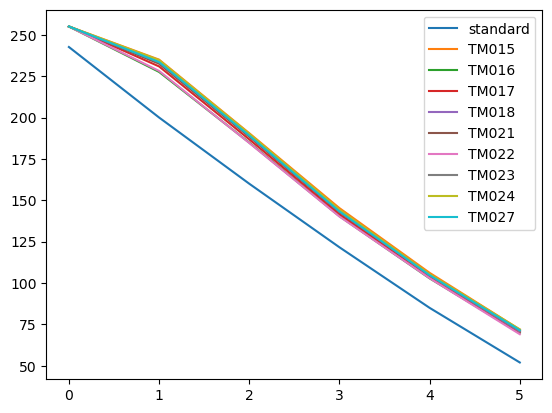

In [115]:
df.plot.line()

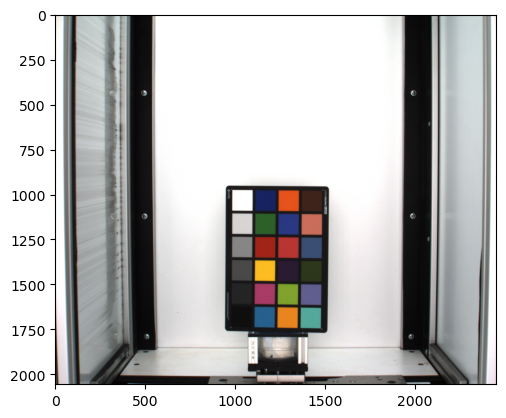

In [119]:
img, _, _ = pcv.readimage(filename="./color_cards/all/TM15_VIS_SV_0_z1_h1_g0_e65_v500_46820_0.png")

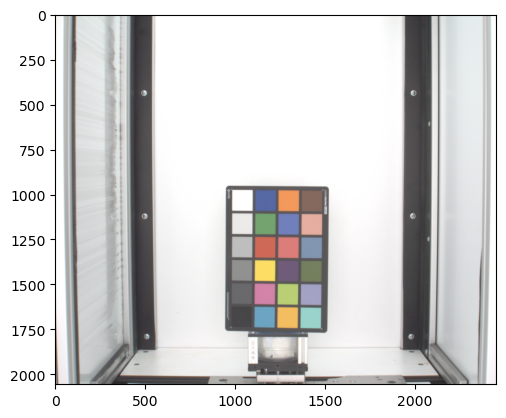

In [120]:
img = pcv.transform.gamma_correct(img=img, gamma=0.45, gain=1)

In [121]:
df, start_coord, spacing = pcv.transform.find_color_card(rgb_img=img)

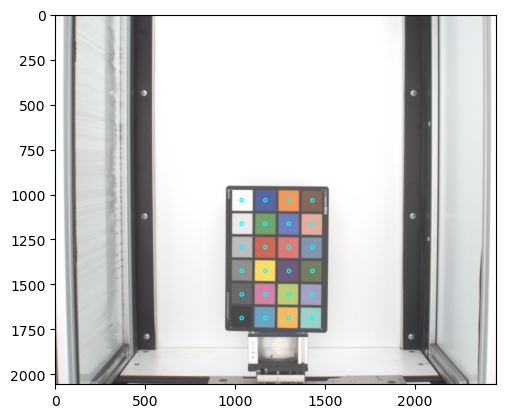

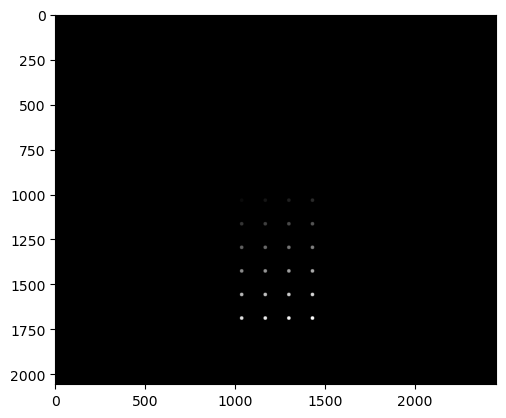

In [122]:
mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4)

In [123]:
mat_t = std_color_matrix(pos=3)

In [124]:
header, mat_s = pcv.transform.get_color_matrix(rgb_img=img, mask=mask)

In [125]:
img_cc = affine_color_correction(img=img, source_matrix=mat_s, target_matrix=mat_t)

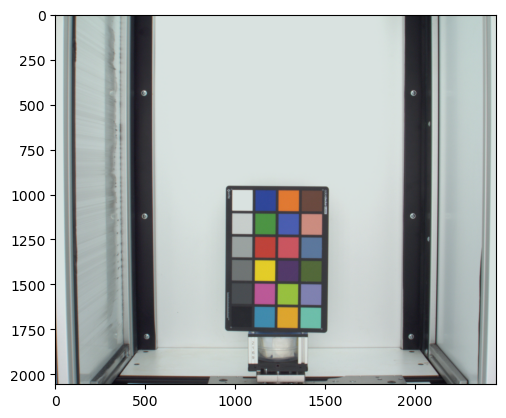

In [126]:
pcv.plot_image(img_cc)

# Winner

In [10]:
def average_gray_values_cc(filename):
    pcv.params.debug = None
    img, _, _ = pcv.readimage(filename=filename)
    img = pcv.transform.gamma_correct(img=img, gamma=0.45, gain=1)
    #pcv.print_image(img, filename+"_gamma.png")
    df, start_coord, spacing = pcv.transform.find_color_card(rgb_img=img)
    mask1 = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4)
    mask2 = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4, exclude=[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19,21,22,23])
    mat_t = std_color_matrix(pos=3)
    header, mat_s = pcv.transform.get_color_matrix(rgb_img=img, mask=mask1)
    print(np.array2string(mat_s, separator=",", floatmode="fixed"))
    img_cc = affine_color_correction(img=img, source_matrix=mat_s, target_matrix=mat_t)
    pcv.print_image(img_cc, filename+"_cc.png")
    gray_img = pcv.rgb2gray(rgb_img=img_cc)
    vals = list()
    for i in range(1, 7):
        vals.append(np.mean(gray_img[np.where(mask2 == i*10)]))
    pcv.params.debug = "plot"
    return vals

[[ 10.00000000,  1.00000000,  1.00000000,  1.00000000],
 [ 20.00000000,  0.33799715,  0.41083689,  0.64952063],
 [ 30.00000000,  0.95574937,  0.60530711,  0.36205851],
 [ 40.00000000,  0.52613348,  0.41337292,  0.36518835],
 [ 50.00000000,  0.93042618,  0.92071504,  0.91878518],
 [ 60.00000000,  0.45403600,  0.64629183,  0.43609822],
 [ 70.00000000,  0.44316200,  0.50621637,  0.74199295],
 [ 80.00000000,  0.90042680,  0.68518587,  0.62668399],
 [ 90.00000000,  0.74872271,  0.75046700,  0.74786912],
 [100.00000000,  0.81505536,  0.41698522,  0.34421971],
 [110.00000000,  0.86801509,  0.49584957,  0.47970557],
 [120.00000000,  0.51556875,  0.58828478,  0.69904126],
 [130.00000000,  0.57090369,  0.57045834,  0.56748933],
 [140.00000000,  0.99679594,  0.87480671,  0.39834230],
 [150.00000000,  0.44154141,  0.36348117,  0.47848086],
 [160.00000000,  0.45683182,  0.50485557,  0.37463970],
 [170.00000000,  0.41760376,  0.41886559,  0.42416033],
 [180.00000000,  0.82851488,  0.52148203,  0.657

<AxesSubplot:>

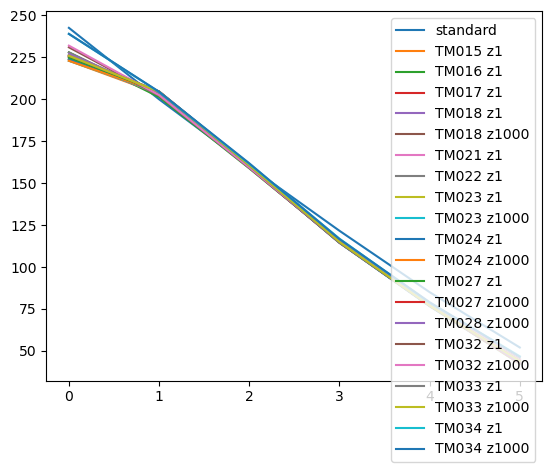

In [11]:
df = pd.DataFrame({
    "standard": [242.6, 200, 160, 121.6, 85, 52],
    "TM015 z1": average_gray_values_cc(filename="color_cards/all/TM15_VIS_SV_0_z1_h1_g0_e65_v500_46820_0.png"),
    "TM016 z1": average_gray_values_cc(filename="color_cards/all/TM16_VIS_SV_0_z1_h1_g0_e65_v500_80231_0.png"),
    "TM017 z1": average_gray_values_cc(filename="color_cards/all/TM17_VIS_SV_0_z1_h1_g0_e65_v500_338057_0.png"),
    "TM018 z1": average_gray_values_cc(filename="color_cards/all/TM18_VIS_SV_0_z1_h1_g0_e65_v500_509982_0.png"),
    "TM018 z1000": average_gray_values_cc(filename="color_cards/all/TM18_VIS_SV_0_z1000_h1_g0_e65_v500_463479_0.png"),
    "TM021 z1": average_gray_values_cc(filename="color_cards/all/TM21_VIS_SV_0_z1_h1_g0_e65_v500_180956_0.png"),
    "TM022 z1": average_gray_values_cc(filename="color_cards/all/TM22_VIS_SV_0_z1_h1_g0_e65_v500_220562_0.png"),
    "TM023 z1": average_gray_values_cc(filename="color_cards/all/TM23_VIS_SV_0_z1_h1_g0_e65_v500_371059_0.png"),
    "TM023 z1000": average_gray_values_cc(filename="color_cards/all/TM23_VIS_SV_0_z1000_h1_g0_e65_v500_316333_0.png"),
    "TM024 z1": average_gray_values_cc(filename="color_cards/all/TM24_VIS_SV_0_z1_h1_g0_e65_v500_500911_0.png"),
    "TM024 z1000": average_gray_values_cc(filename="color_cards/all/TM24_VIS_SV_0_z1000_h1_g0_e65_v500_454465_0.png"),
    "TM027 z1": average_gray_values_cc(filename="color_cards/all/TM27_VIS_SV_0_z1_h1_g0_e65_v500_158756_0.png"),
    "TM027 z1000": average_gray_values_cc(filename="color_cards/all/TM27_VIS_SV_0_z1000_h1_g0_e65_v500_61520_0.png"),
    "TM028 z1000": average_gray_values_cc(filename="color_cards/all/TM28_VIS_SV_0_z1000_h1_g0_e65_v500_273632_0.png"),
    "TM032 z1": average_gray_values_cc(filename="color_cards/all/TM32_VIS_SV_0_z1_h1_g0_e65_v500_285692_0.png"),
    "TM032 z1000": average_gray_values_cc(filename="color_cards/all/TM32_VIS_SV_0_z1000_h1_g0_e65_v500_285698_0.png"),
    "TM033 z1": average_gray_values_cc(filename="color_cards/all/TM33_VIS_SV_0_z1_h1_g0_e65_v500_432935_0.png"),
    "TM033 z1000": average_gray_values_cc(filename="color_cards/all/TM33_VIS_SV_0_z1000_h1_g0_e65_v500_432929_0.png"),
    "TM034 z1": average_gray_values_cc(filename="color_cards/all/TM34_VIS_SV_0_z1_h1_g0_e65_v500_38_0.png"),
    "TM034 z1000": average_gray_values_cc(filename="color_cards/all/TM34_VIS_SV_0_z1000_h1_g0_e65_v500_50_0.png"),
}, index=[0, 1, 2, 3, 4, 5])
df.plot.line()

In [31]:
v = average_gray_values_cc(filename="color_cards/all/TM34_VIS_SV_0_z1000_h1_g0_e65_v500_50_0.png")

[[ 10.00000000,  1.00000000,  1.00000000,  0.99933197],
 [ 20.00000000,  0.30292571,  0.37905610,  0.59289912],
 [ 30.00000000,  0.87516546,  0.57000062,  0.32612111],
 [ 40.00000000,  0.47995299,  0.38456114,  0.33172512],
 [ 50.00000000,  0.85389992,  0.87151605,  0.84131874],
 [ 60.00000000,  0.42110472,  0.60703903,  0.39899796],
 [ 70.00000000,  0.40403291,  0.46792850,  0.67361910],
 [ 80.00000000,  0.81670069,  0.64113317,  0.56731614],
 [ 90.00000000,  0.68773427,  0.70521433,  0.68345395],
 [100.00000000,  0.73356838,  0.38397971,  0.30956887],
 [110.00000000,  0.77793035,  0.46048123,  0.43675388],
 [120.00000000,  0.46774293,  0.54515989,  0.62987567],
 [130.00000000,  0.51770891,  0.52735820,  0.51261211],
 [140.00000000,  0.90732975,  0.81844498,  0.35655347],
 [150.00000000,  0.39108060,  0.33113132,  0.42935610],
 [160.00000000,  0.41141832,  0.46520690,  0.33020350],
 [170.00000000,  0.37003773,  0.38060246,  0.37309334],
 [180.00000000,  0.72031917,  0.46544195,  0.576

In [134]:
def average_gray_values_cc2(filename):
    pcv.params.debug = None
    img, _, _ = pcv.readimage(filename=filename)
    df, start_coord, spacing = pcv.transform.find_color_card(rgb_img=img)
    mask1 = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4)
    mask2 = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start_coord, 
                                                spacing=spacing, nrows=6, ncols=4, exclude=[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19,21,22,23])
    mat_t = std_color_matrix(pos=3)
    header, mat_s = pcv.transform.get_color_matrix(rgb_img=img, mask=mask1)
    mat_a, mat_m, mat_b = pcv.transform.get_matrix_m(target_matrix=mat_t, source_matrix=mat_s)
    det, mat_t = pcv.transform.calc_transformation_matrix(matrix_m=mat_m, matrix_b=mat_b)
    img_cc = pcv.transform.apply_transformation_matrix(source_img=img, target_img=img, transformation_matrix=mat_t)
    # img_cc = affine_color_correction(img=img, source_matrix=mat_s, target_matrix=mat_t)
    pcv.print_image(img_cc, filename+"_cc.png")
    gray_img = pcv.rgb2gray(rgb_img=img_cc)
    vals = list()
    for i in range(1, 7):
        vals.append(np.mean(gray_img[np.where(mask2 == i*10)]))
    pcv.params.debug = "plot"
    return vals

<AxesSubplot:>

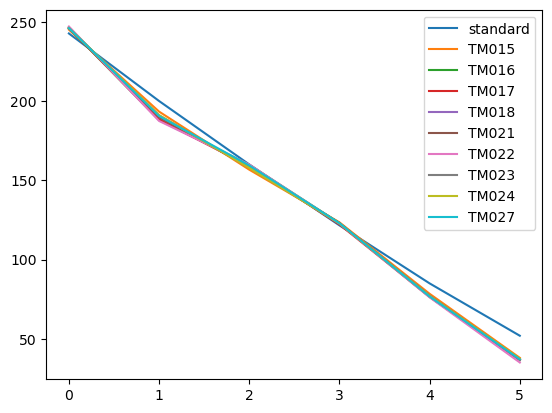

In [135]:
df = pd.DataFrame({
    "standard": [242.6, 200, 160, 121.6, 85, 52],
    "TM015": average_gray_values_cc2(filename="color_cards/all/TM15_VIS_SV_0_z1_h1_g0_e65_v500_46820_0.png"),
    "TM016": average_gray_values_cc2(filename="color_cards/all/TM16_VIS_SV_0_z1_h1_g0_e65_v500_80231_0.png"),
    "TM017": average_gray_values_cc2(filename="color_cards/all/TM17_VIS_SV_0_z1_h1_g0_e65_v500_338057_0.png"),
    "TM018": average_gray_values_cc2(filename="color_cards/all/TM18_VIS_SV_0_z1_h1_g0_e65_v500_509982_0.png"),
    "TM021": average_gray_values_cc2(filename="color_cards/all/TM21_VIS_SV_0_z1_h1_g0_e65_v500_180956_0.png"),
    "TM022": average_gray_values_cc2(filename="color_cards/all/TM22_VIS_SV_0_z1_h1_g0_e65_v500_220562_0.png"),
    "TM023": average_gray_values_cc2(filename="color_cards/all/TM23_VIS_SV_0_z1_h1_g0_e65_v500_371059_0.png"),
    "TM024": average_gray_values_cc2(filename="color_cards/all/TM24_VIS_SV_0_z1_h1_g0_e65_v500_500911_0.png"),
    "TM027": average_gray_values_cc2(filename="color_cards/all/TM27_VIS_SV_0_z1_h1_g0_e65_v500_158756_0.png"),
}, index=[0, 1, 2, 3, 4, 5])
df.plot.line()